<a href="https://colab.research.google.com/github/YCCS-Summer-2023-DDNMA/project/blob/80-practice-with-neural-networks-mk/Michael_Kupferstein/nn_from_scratch/nnScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP training on MNIST

In [81]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import jax
from jax import jit,vmap,pmap,grad,value_and_grad

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

In [82]:
seed = 0
mnist_img_size = (28,28)

def init_MLP(layer_widths,parent_key,scale=0.01):

  params = []
  keys = jax.random.split(parent_key,num=len(layer_widths)-1)

  for in_width,out_width,key in zip(layer_widths[:-1],layer_widths[1:],keys):
    weight_key, bias_key = jax.random.split(key)
    params.append([
            scale*jax.random.normal(weight_key,shape=(out_width,in_width)),
            scale*jax.random.normal(bias_key,shape=(out_width,))
            ]
    )

  return params

# test
key = jax.random.PRNGKey(seed)
MLP_params = init_MLP([784,512,256,10],key)
print(jax.tree_map(lambda x:x.shape,MLP_params))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


In [83]:
def MLP_predict(params,x):
  hidden_layers = params[:-1]

  activation = x
  for w,b in hidden_layers:
    activation = jax.nn.relu(jnp.dot(w,activation) + b)

  w_last,b_last = params[-1]
  logits = jnp.dot(w_last,activation) + b_last

  # log(exp(o1)) - log(sum(exp(o1),exp(o2),...exp(o10)))
  # log(exp(o1)/ sum(...))
  return logits - logsumexp(logits)

# tests

# test single example

dummy_img_flat = np.random.randn(np.prod(mnist_img_size))
print(dummy_img_flat.shape)

predications = MLP_predict(MLP_params,dummy_img_flat)
print(predications.shape)

# test batched function
batched_MLP_predict = vmap(MLP_predict,in_axes=(None,0))

dummy_imgs_flat = np.random.randn(16, np.prod(mnist_img_size))
print(dummy_imgs_flat.shape)
predications = batched_MLP_predict(MLP_params, dummy_imgs_flat)
print(predications.shape)

(784,)
(10,)
(16, 784)
(16, 10)


In [84]:
def custom_transform(x):
  return np.ravel(np.array(x,dtype=np.float32))

def custom_collate_fn(batch):
  transposed_data = list(zip(*batch))

  labels = np.array(transposed_data[1])
  imgs = np.stack(transposed_data[0])

  return imgs, labels

batch_size = 128
train_dataset = MNIST(root='train_mnist',train=True,download=True,transform=custom_transform)
test_dataset = MNIST(root='test_mnist',train=False,download=True,transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn,drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn,drop_last=True)

# test
batch_data = next(iter(train_loader))
imgs = batch_data[0]
lbls = batch_data[1]
print(imgs.shape,imgs[0].dtype,lbls.shape,lbls[0].dtype)

# optimization - load the whole dataset into memory
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset),-1)
train_lbls = jnp.array(train_dataset.targets)

test_images = jnp.array(test_dataset.data).reshape(len(test_dataset),-1)
test_lbls = jnp.array(test_dataset.targets)

(128, 784) float32 (128,) int64


In [ ]:
num_epochs = 5

def loss_fn(params,imgs,gt_lbls):
  predictions = batched_MLP_predict(params,imgs) # (b,10)

  return -jnp.mean(predictions * gt_lbls)

def accuracy(params,dataset_imgs,dataset_lbls):
  pred_classes = jnp.argmax(batched_MLP_predict(params,dataset_imgs),axis=1)
  return jnp.mean(dataset_lbls == pred_classes)

@jit
def update(params,imgs,gt_lbls,lr=0.01):
  loss, grads = value_and_grad(loss_fn)(params,imgs,gt_lbls)

  return loss, jax.tree_map(lambda p,g: p-lr*g,params,grads)

# Create a MLP
MLP_params = init_MLP([np.prod(mnist_img_size),512,256,len(MNIST.classes)],key)

for epoch in range(num_epochs):

  for cnt,(imgs,lbls) in enumerate(train_loader):

    gt_labels = jax.nn.one_hot(lbls,len(MNIST.classes))

    loss, MLP_params = update(MLP_params,imgs,gt_labels)

    if cnt % 50 == 0:
      print(loss)

  print(f'Epoch {epoch},train acc={accuracy(MLP_params,train_images,train_lbls)} test acc={accuracy(MLP_params,test_images,test_lbls)}')

(28, 28)
pred 7
gt 7


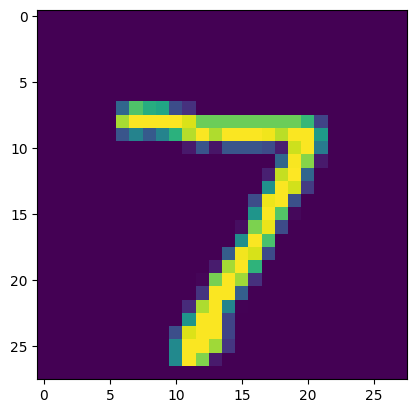

In [86]:
imgs,lbls = next(iter(test_loader))
img = imgs[0].reshape(mnist_img_size)
gt_lbl = lbls[0]
print(img.shape)

import matplotlib.pyplot as plt

pred = jnp.argmax(MLP_predict(MLP_params,np.ravel(img)))
print('pred',pred)
print('gt',gt_lbl)

plt.imshow(img); plt.show()

# Visualizations

In [ ]:
# todo: visulaize emedding using t-SNE
# todo: dead neurons

(512, 784)
(28, 28)


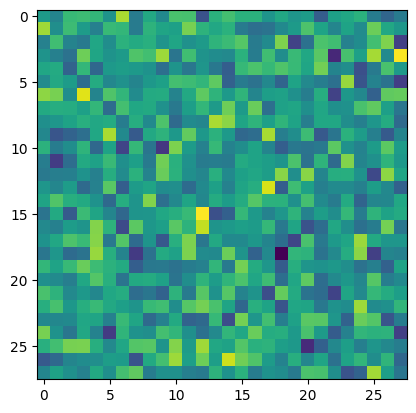

In [91]:
w = MLP_params[0][0]
print(w.shape)

w_single = w[0,:].reshape(mnist_img_size)
print(w_single.shape)
plt.imshow(w_single); plt.show()

(128, 256)


KeyError: ignored

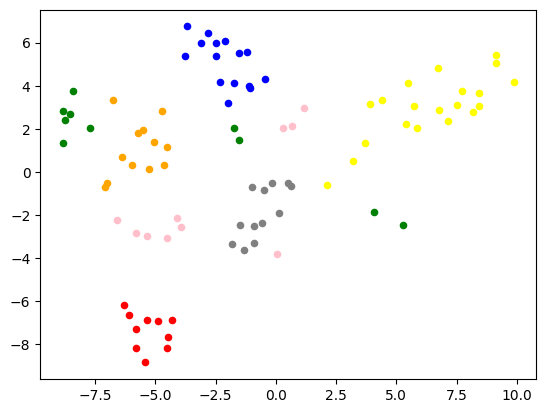

In [95]:
from sklearn.manifold import TSNE

def fetch_activations(params,x):
  hidden_layers = params[:-1]

  activation = x
  for w,b in hidden_layers:
    activation = jax.nn.relu(jnp.dot(w,activation) + b)

  return activation

batched_fetch_activations = vmap(fetch_activations,in_axes=(None,0))
imgs, lbls = next(iter(test_loader))

batch_activations = batched_fetch_activations(MLP_params,imgs)
print(batch_activations.shape)  # (128, 2)

t_sne_embeddings = TSNE(n_components=2, perplexity=30,).fit_transform(batch_activations)
cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

for class_id in range(10):
    plt.scatter(t_sne_embeddings[lbls == class_id, 0], t_sne_embeddings[lbls == class_id, 1], s=20, color=cora_label_to_color_map[class_id])
plt.show()

# Parallelization